In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from stfe.gene_utils import get_markers
import scanpy as sc
from plotly3d.plot import trajectories
from sklearn.cluster import KMeans
import pandas as pd
import pathlib

In [2]:
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

In [4]:
n = 2
traj = np.load(f'../data/traj_gene_space_{n}.npy')

In [5]:
gene_names = adata.var_names.to_numpy()

In [6]:
traj_mean = traj.mean(axis=1)
traj_std = traj.std(axis=1)
traj_mean_std = traj_mean.std(axis=0)
zero_std_genes = traj_mean_std == 0
gene_names = np.array(gene_names)[~zero_std_genes]
traj, traj_mean, traj_std, traj_mean_std = traj[..., ~zero_std_genes], traj_mean[..., ~zero_std_genes], traj_std[..., ~zero_std_genes], traj_mean_std[..., ~zero_std_genes]
traj_mean_normalized = (traj_mean - traj_mean.mean(axis=0)) / traj_mean.std(axis=0)

In [7]:
assert gene_names.shape[0] == traj_mean_normalized.shape[1]

In [8]:
trends_df = pd.DataFrame(traj_mean_normalized, columns=gene_names, index=[f't{i}' for i in range(traj_mean_normalized.shape[0])]).T

In [9]:
adata.var

,gene_ids,feature_types,genome,n_counts,is_emt,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,79.0,False,False,0.001975,0.286789,-0.344582
AL669831.5,ENSG00000237491,Gene Expression,GRCh38,1857.0,False,False,0.046333,0.386439,-0.202066
FAM87B,ENSG00000177757,Gene Expression,GRCh38,414.0,False,False,0.015271,0.203745,-0.463349
LINC00115,ENSG00000225880,Gene Expression,GRCh38,1029.0,False,False,0.032222,0.430821,-0.138592
FAM41C,ENSG00000230368,Gene Expression,GRCh38,2041.0,False,False,0.079435,0.327309,-0.286631
...,...,...,...,...,...,...,...,...,...
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,410.0,False,False,0.017812,0.277091,-0.358452
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,4716.0,False,False,0.207128,0.320736,-0.296032
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,311.0,False,False,0.001879,0.492349,-0.050596
AC004556.1,ENSG00000276345,Gene Expression,GRCh38,36.0,False,False,0.001950,0.209043,-0.455772


In [10]:
km = KMeans(random_state=42, n_clusters=5)
km.fit(trends_df)
cluster_labels = km.labels_
start_vals = [km.cluster_centers_[i][0] for i in range(km.n_clusters)]
sorted_indices = np.argsort(start_vals)[::-1]  # Sort indices in descending order
reorder_map = {old_label: new_label for new_label, old_label in enumerate(sorted_indices)}
reordered_labels = np.array([reorder_map[label] for label in cluster_labels])
cluster_labels = reordered_labels

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(-2.5, 2.5)

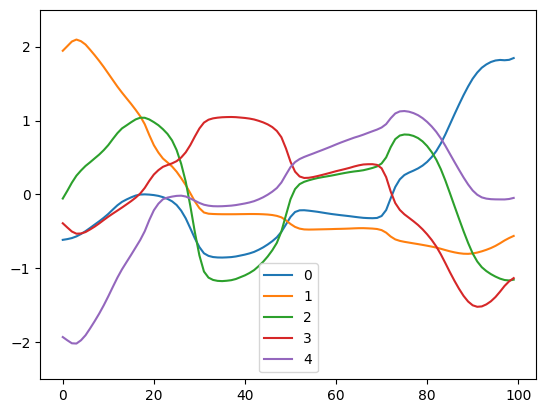

In [11]:
for i in range(len(np.unique(km.labels_))):
    plt.plot(km.cluster_centers_[i], label=i)
plt.legend()
plt.ylim(-2.5, 2.5)

In [12]:
# Use the predefined tab20 colormap
import matplotlib.pyplot as plt

# Function to convert numbers to colors using tab20 colormap
def lut(number):
    cmap = plt.get_cmap('tab20')
    return cmap(number / 20)  # Normalize the input to [0, 1]

In [13]:
row_colors = pd.Series(km.labels_, index=trends_df.index).apply(lut).rename("Cluster")

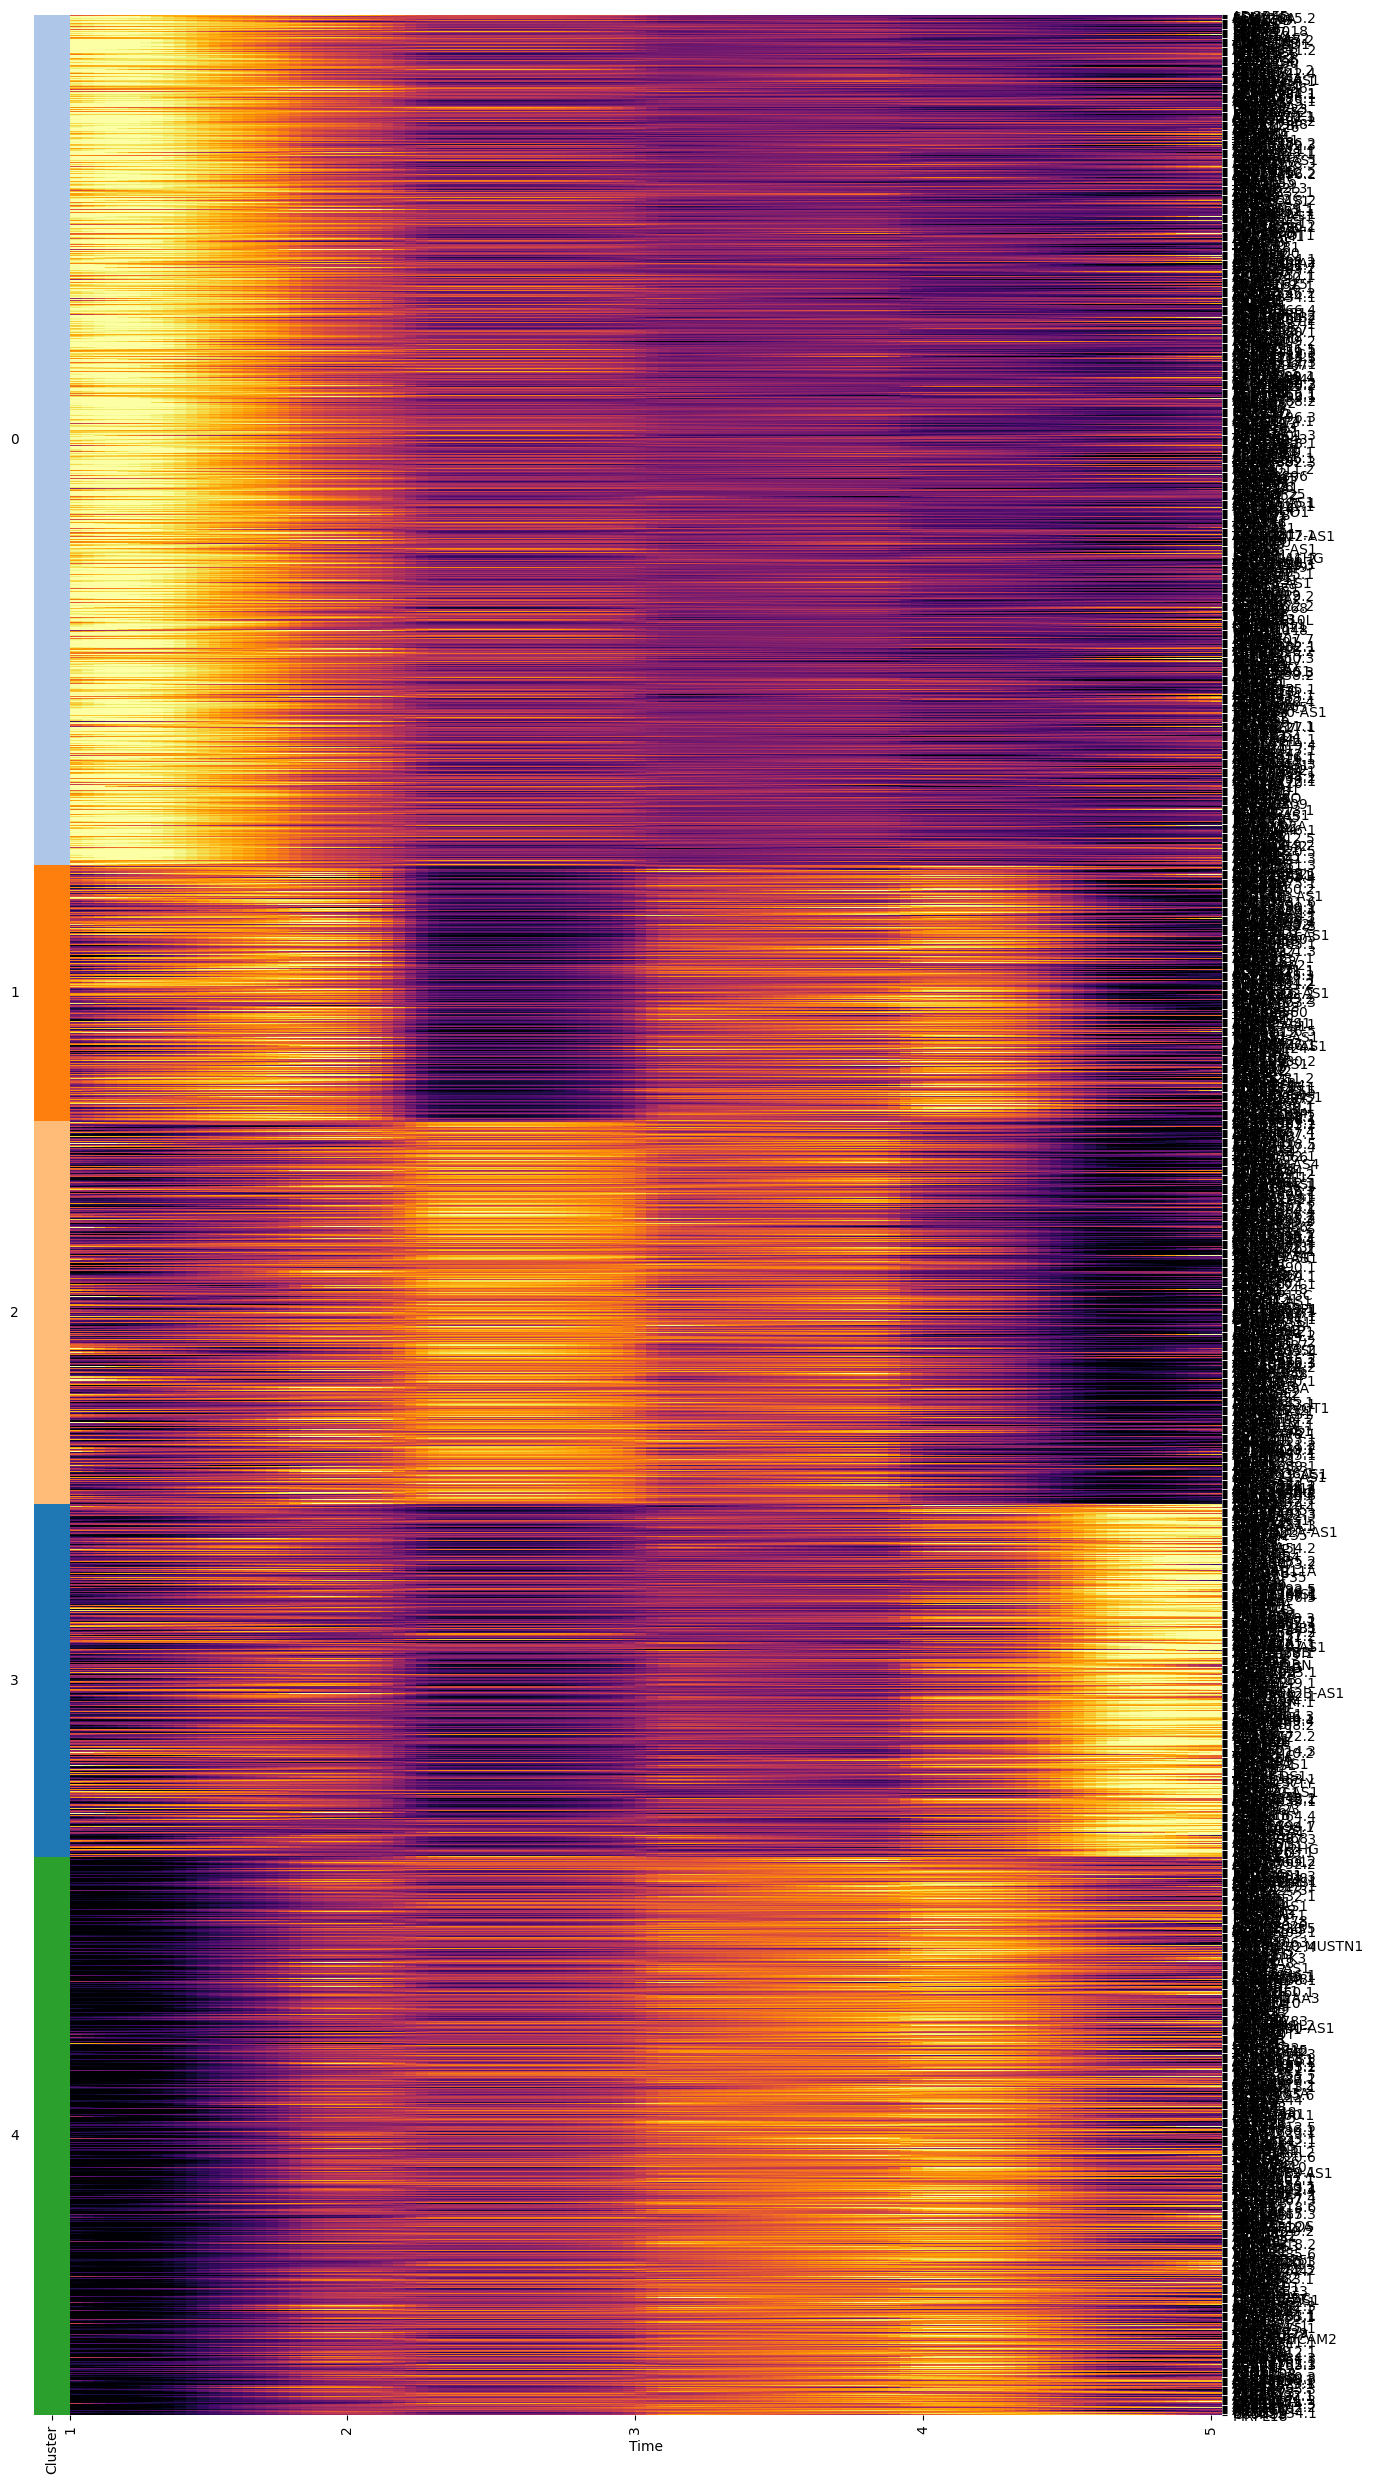

In [14]:
results_dir = pathlib.Path('../results/')
results_dir.mkdir(exist_ok=True)

np.random.seed(23)

# Sort the DataFrame by cluster labels
sorted_df = trends_df.iloc[np.argsort(cluster_labels)]
sorted_row_colors = row_colors.iloc[np.argsort(cluster_labels)]
sorted_cluster_labels = cluster_labels[np.argsort(cluster_labels)]

cl = sns.clustermap(
    sorted_df, col_cluster=False, cmap="inferno", robust=True, row_colors=sorted_row_colors,
    row_cluster=False,  # Disable row clustering to maintain the order
    cbar_pos=None,  # Remove the colorbar
    figsize=(12, 24)  # Adjust figure size for better layout
)
ax = cl.ax_heatmap
ax.set_xticks([0, 24, 49, 74, 99])
ax.set_xticklabels(np.arange(5) + 1)
names = sorted_df.index

# Set y-ticks to show one label every 100 genes
y_tick_positions = np.arange(0, len(names), 10)
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(names[y_tick_positions])

ax.set_xlabel("Time")

# Adjust layout to remove extra margins
plt.tight_layout()

# Adjust the position of the main axes to fill the figure
cl.ax_heatmap.set_position([0.04, 0, 0.96, 1])

# Adjust the position of the row colors to align with the main heatmap
cl.ax_row_colors.set_position([0.01, 0, 0.03, 1])

# Add cluster labels to the left of the color blocks
ax_cluster_labels = cl.fig.add_axes([0, 0, 0.01, 1])
ax_cluster_labels.set_axis_off()

unique_labels = np.unique(sorted_cluster_labels)
for label in unique_labels:
    label_positions = np.where(sorted_cluster_labels == label)[0]
    mid_position = 1 - (label_positions[0] + label_positions[-1]) / 2 / len(sorted_cluster_labels)
    ax_cluster_labels.text(-0.3, mid_position, f'{label}', 
                           ha='right', va='center', transform=ax_cluster_labels.transAxes)

plt.savefig(results_dir / f'cluster_heatmap_{n}.png', bbox_inches='tight', pad_inches=0.1)

# Save the data frames
sorted_df.to_csv(results_dir / f'sorted_df_{n}.csv')
pd.DataFrame(sorted_row_colors).to_csv(results_dir / f'sorted_row_colors_{n}.csv')
pd.DataFrame({'cluster_labels': sorted_cluster_labels}).to_csv(results_dir / f'sorted_cluster_labels_{n}.csv')


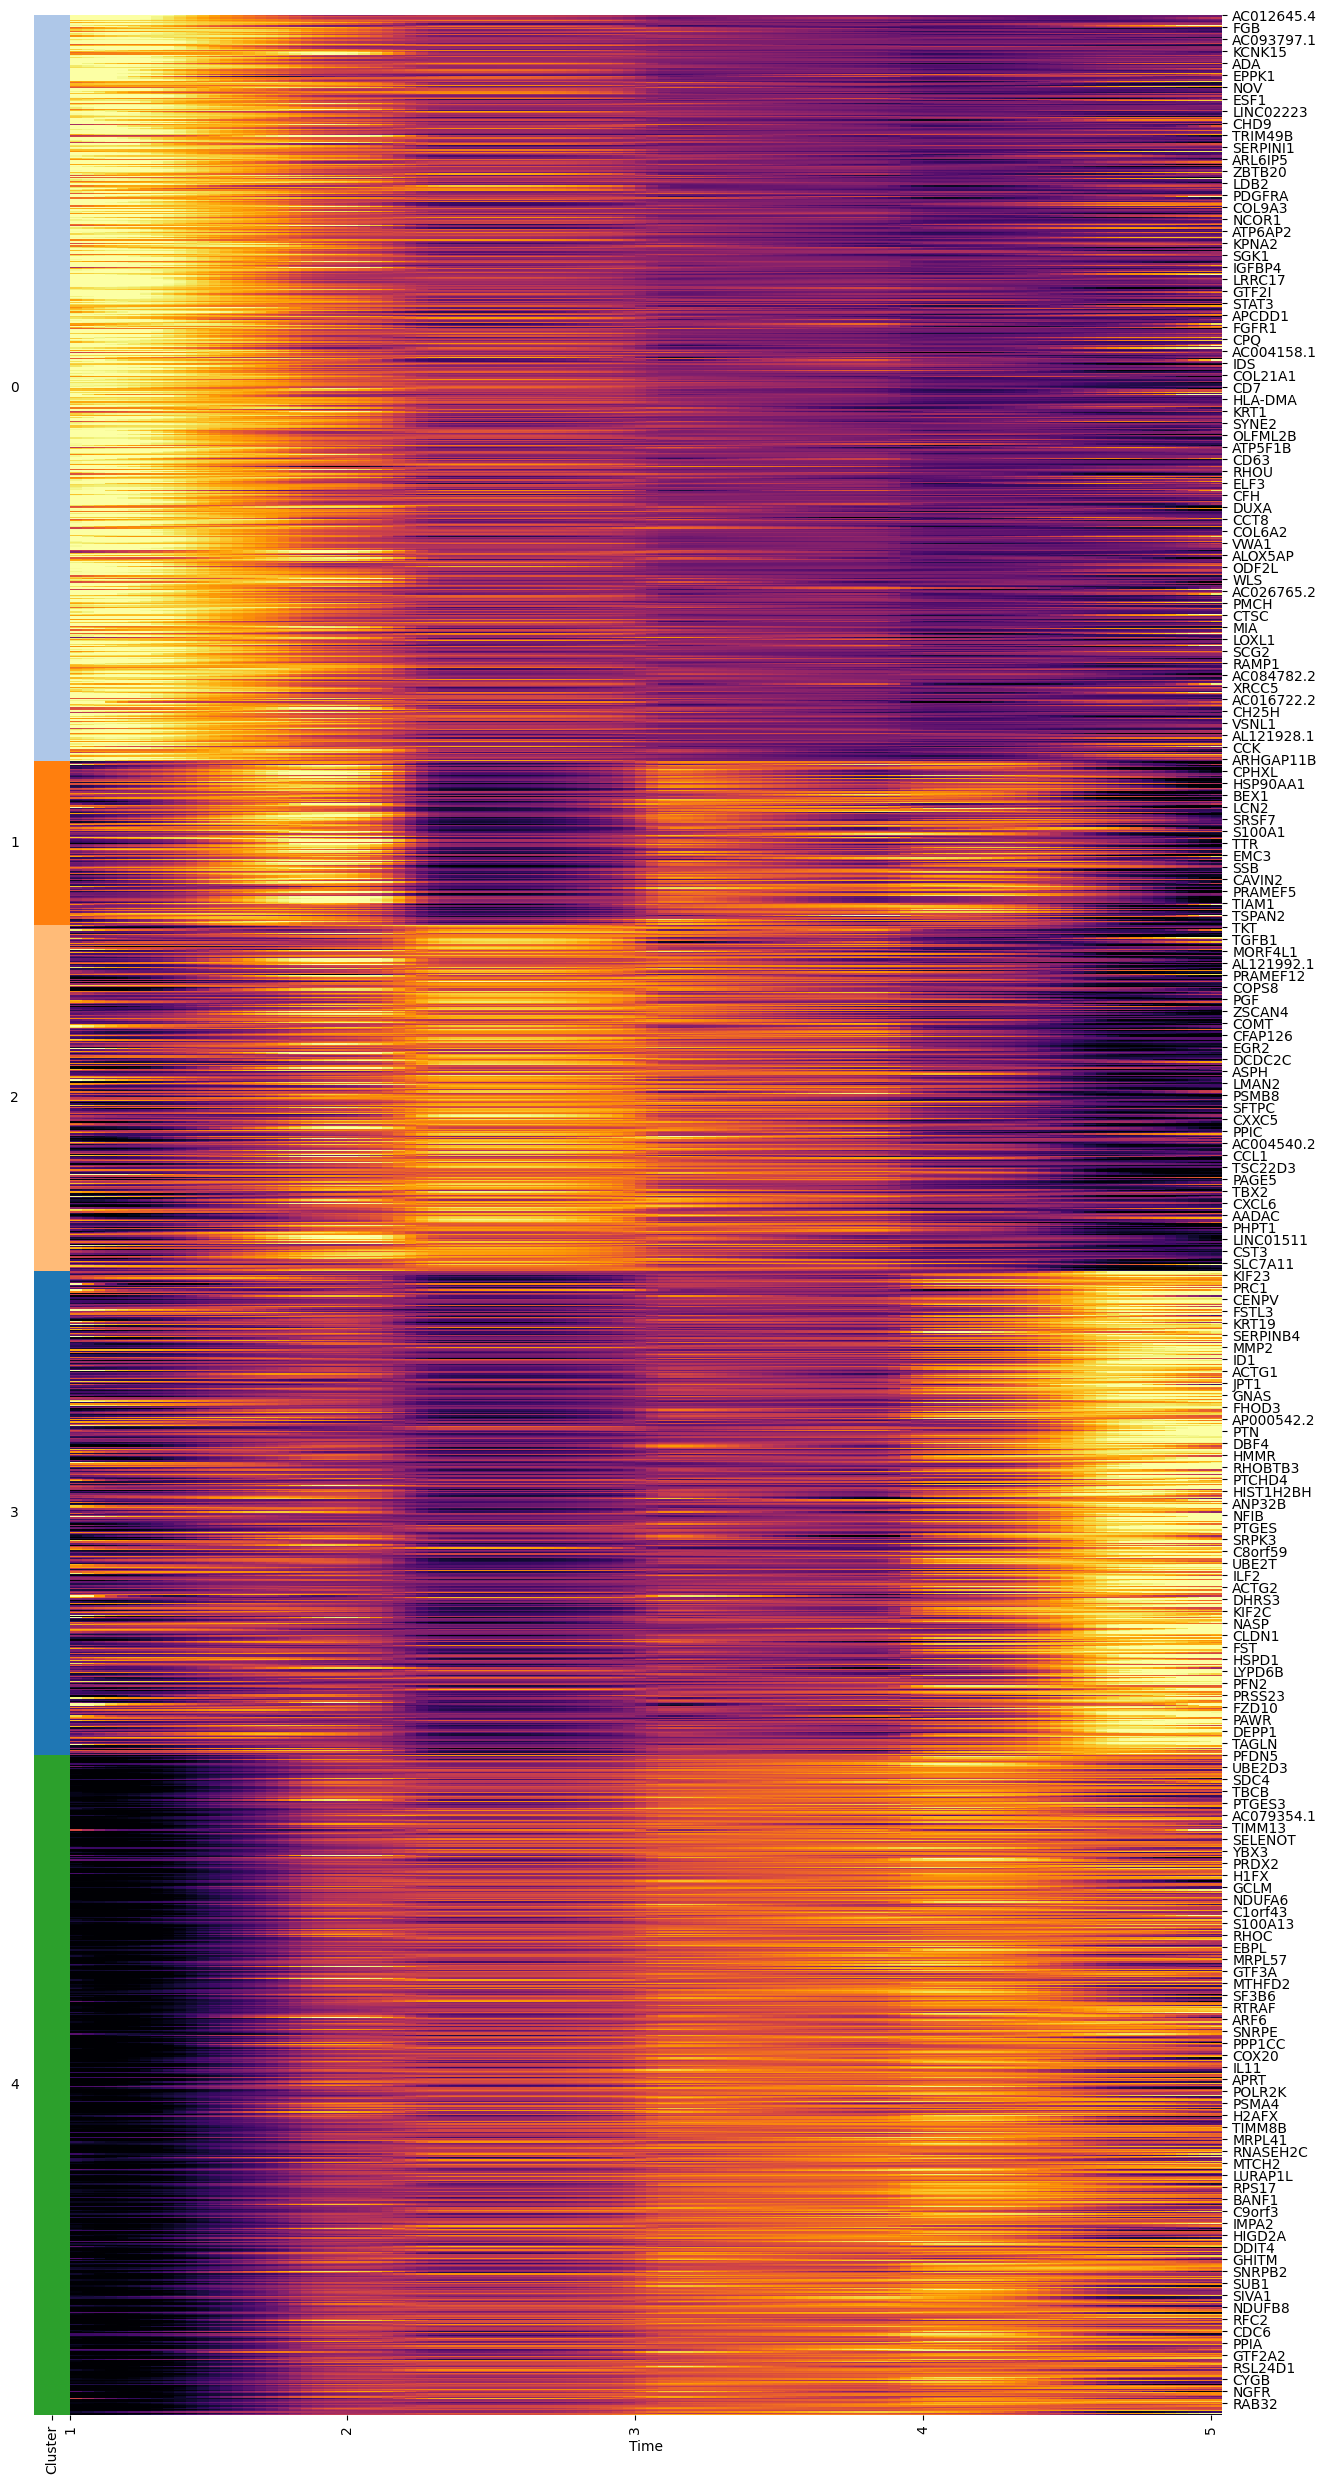

In [15]:
results_dir = pathlib.Path('../results/')
results_dir.mkdir(exist_ok=True)

np.random.seed(23)

# Sort the DataFrame by cluster labels
sorted_df = trends_df.iloc[np.argsort(cluster_labels)]
sorted_row_colors = row_colors.iloc[np.argsort(cluster_labels)]
sorted_cluster_labels = cluster_labels[np.argsort(cluster_labels)]
sorted_cluster_labels = pd.Series(sorted_cluster_labels, index=sorted_df.index)

sorted_df_hvg = sorted_df.loc[adata.var['highly_variable'],:]
sorted_row_colors_hvg = sorted_row_colors.loc[sorted_df_hvg.index]
sorted_cluster_labels_hvg = sorted_cluster_labels.loc[sorted_df_hvg.index]

cl = sns.clustermap(
    sorted_df_hvg, col_cluster=False, cmap="inferno", robust=True, row_colors=sorted_row_colors_hvg,
    row_cluster=False,  # Disable row clustering to maintain the order
    cbar_pos=None,  # Remove the colorbar
    figsize=(12, 24)  # Adjust figure size for better layout
)
ax = cl.ax_heatmap
ax.set_xticks([0, 24, 49, 74, 99])
ax.set_xticklabels(np.arange(5) + 1)
names = sorted_df_hvg.index

# Set y-ticks to show one label every 100 genes
y_tick_positions = np.arange(0, len(names), 10)
ax.set_yticks(y_tick_positions)
ax.set_yticklabels(names[y_tick_positions])

ax.set_xlabel("Time")

# Adjust layout to remove extra margins
plt.tight_layout()

# Adjust the position of the main axes to fill the figure
cl.ax_heatmap.set_position([0.04, 0, 0.96, 1])

# Adjust the position of the row colors to align with the main heatmap
cl.ax_row_colors.set_position([0.01, 0, 0.03, 1])

# Add cluster labels to the left of the color blocks
ax_cluster_labels = cl.fig.add_axes([0, 0, 0.01, 1])
ax_cluster_labels.set_axis_off()

unique_labels = np.unique(sorted_cluster_labels_hvg)
for label in unique_labels:
    label_positions = np.where(sorted_cluster_labels_hvg == label)[0]
    mid_position = 1 - (label_positions[0] + label_positions[-1]) / 2 / len(sorted_cluster_labels_hvg)
    ax_cluster_labels.text(-0.3, mid_position, f'{label}', 
                           ha='right', va='center', transform=ax_cluster_labels.transAxes)

plt.savefig(results_dir / f'cluster_heatmap_{n}_highly_variable.png', bbox_inches='tight', pad_inches=0.1)

# Save the data frames
sorted_df_hvg.to_csv(results_dir / f'sorted_df_hvg_{n}.csv')
pd.DataFrame(sorted_row_colors_hvg).to_csv(results_dir / f'sorted_row_colors_hvg_{n}.csv')
pd.DataFrame({'cluster_labels': sorted_cluster_labels_hvg}).to_csv(results_dir / f'sorted_cluster_labels_hvg_{n}.csv')
